In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ashishjangra27/face-mask-12k-images-dataset


 99% 327M/330M [00:01<00:00, 244MB/s]
100% 330M/330M [00:01<00:00, 204MB/s]


In [ ]:
! unzip /content/face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
import tensorflow as tf
import os 
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import h5py
from sklearn.metrics import classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import tensorflow_hub as tf_hub

In [18]:
img = cv.imread("/content/Face Mask Dataset/Train/WithMask/1024.png")
img_2 = cv.imread("/content/Face Mask Dataset/Train/WithoutMask/1035.png")
cv.imwrite("/content/Face Mask Dataset/Test/WithMask/5660005.png",img)
cv.imwrite("/content/Face Mask Dataset/Test/WithoutMask/969060.png",img_2)

# in test data...1 images in both with and without mask is not png ....so we takinge each 1 img 
# so that its easy to make even count batches

True

In [16]:
total_test_withMask_count = len(os.listdir("/content/Face Mask Dataset/Test/WithMask"))
total_test_withOutMask_count = len(os.listdir("/content/Face Mask Dataset/Test/WithoutMask"))
total_train_withMask_count = len(os.listdir("/content/Face Mask Dataset/Train/WithMask"))
total_train_withOutMask_count = len(os.listdir("/content/Face Mask Dataset/Train/WithoutMask"))
total_val_withMask_count = len(os.listdir("/content/Face Mask Dataset/Validation/WithMask"))
total_val_withOutMask_count = len(os.listdir("/content/Face Mask Dataset/Validation/WithoutMask"))
print(f"total_test_withMask_Count :--- {total_test_withMask_count}")
print(f"total_test_withOutMask_Count :--- {total_test_withOutMask_count}")
print(f"total_train_withMask_Count :--- {total_train_withMask_count}")
print(f"total_train_withOutMask_Count :--- {total_train_withOutMask_count}")
print(f"total_val_withMask_Count :--- {total_val_withMask_count}")
print(f"total_val_withMask_Count :--- {total_val_withOutMask_count}")

total_test_withMask_Count :--- 450
total_test_withOutMask_Count :--- 450
total_train_withMask_Count :--- 5000
total_train_withOutMask_Count :--- 5000
total_val_withMask_Count :--- 400
total_val_withMask_Count :--- 400


In this project we are going to train different model with different size of data , but we using the same (whole) validation and test data to check the performance of all models 

In [19]:
total_train_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Train/*/*.png",shuffle=True)
total_test_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Test/*/*.png",shuffle=True)
total_val_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Validation/*/*.png",shuffle=True)
len(total_train_dataset) ,len(total_test_dataset) , len(total_val_dataset) 

(10000, 900, 800)

In [20]:
for x in total_val_dataset.take(5):
  print(x.numpy())
print()
for x in total_test_dataset.take(5):
  print(x)
print()
for x in total_val_dataset.take(5):
  print(x)

b'/content/Face Mask Dataset/Validation/WithoutMask/3991.png'
b'/content/Face Mask Dataset/Validation/WithoutMask/4152.png'
b'/content/Face Mask Dataset/Validation/WithMask/Augmented_567_9326492.png'
b'/content/Face Mask Dataset/Validation/WithMask/579.png'
b'/content/Face Mask Dataset/Validation/WithoutMask/948.png'

tf.Tensor(b'/content/Face Mask Dataset/Test/WithoutMask/420.png', shape=(), dtype=string)
tf.Tensor(b'/content/Face Mask Dataset/Test/WithMask/Augmented_224_1661606.png', shape=(), dtype=string)
tf.Tensor(b'/content/Face Mask Dataset/Test/WithMask/Augmented_765_7946380.png', shape=(), dtype=string)
tf.Tensor(b'/content/Face Mask Dataset/Test/WithoutMask/3372.png', shape=(), dtype=string)
tf.Tensor(b'/content/Face Mask Dataset/Test/WithoutMask/3170.png', shape=(), dtype=string)

tf.Tensor(b'/content/Face Mask Dataset/Validation/WithMask/Augmented_415_1564436.png', shape=(), dtype=string)
tf.Tensor(b'/content/Face Mask Dataset/Validation/WithoutMask/2094.png', shape=(), dty

In [21]:
dict_lable = {
    1.0 : "WithMask",
    0.0 : "WithOutMask"
}

In [22]:
def get_label_digit(label):
  if label == "WithoutMask":
    return 0
  else:
    return 1

def get_img_label(path):
  label = tf.strings.split(path,os.path.sep)[-2]
  label = get_label_digit(label)
  label = tf.cast(label,tf.float32)

  img = tf.io.read_file(path)
  img = tf.image.decode_png(img)
  img = tf.image.resize(img,[224,224])
  img = img / 255
  return img , label

for x in total_train_dataset.take(1):
  img , label = get_img_label(x)
  print(img.shape)
  print(label)

(224, 224, 3)
tf.Tensor(0.0, shape=(), dtype=float32)


In [23]:
# here we doing batching on all test train and validation 
batchSize = 50
total_train_dataset = total_train_dataset.map(get_img_label).batch(batch_size=batchSize).prefetch(tf.data.AUTOTUNE)
total_val_dataset = total_val_dataset.map(get_img_label).batch(batch_size=batchSize)
total_test_dataset = total_test_dataset.map(get_img_label).batch(batch_size = batchSize)
len(total_train_dataset) , len(total_val_dataset) , len(total_test_dataset)
# here train data is 200 batches 
# val data is 16 batches 
# test we have 18 batches 

(200, 16, 18)

In [24]:
for img ,label in total_train_dataset.take(2):
  print(img.shape)
  print(label)

(50, 224, 224, 3)
tf.Tensor(
[0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0.], shape=(50,), dtype=float32)
(50, 224, 224, 3)
tf.Tensor(
[0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0.], shape=(50,), dtype=float32)


In [25]:
! mkdir models_filesandPics

In [26]:
## now we are preparing the large model with alll 10000 images to train 
largeModel_10000 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224,224,3),batch_size=batchSize),
        tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50,activation="relu"),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2,activation="softmax")
])

In [27]:
largeModel_10000.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [28]:
largeModel_10000.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (50, 224, 224, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (50, 112, 112, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (50, 112, 112, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (50, 56, 56, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (50, 100352)              0         
                                                                 
 batch_normalization (BatchN  (50, 100352)             4

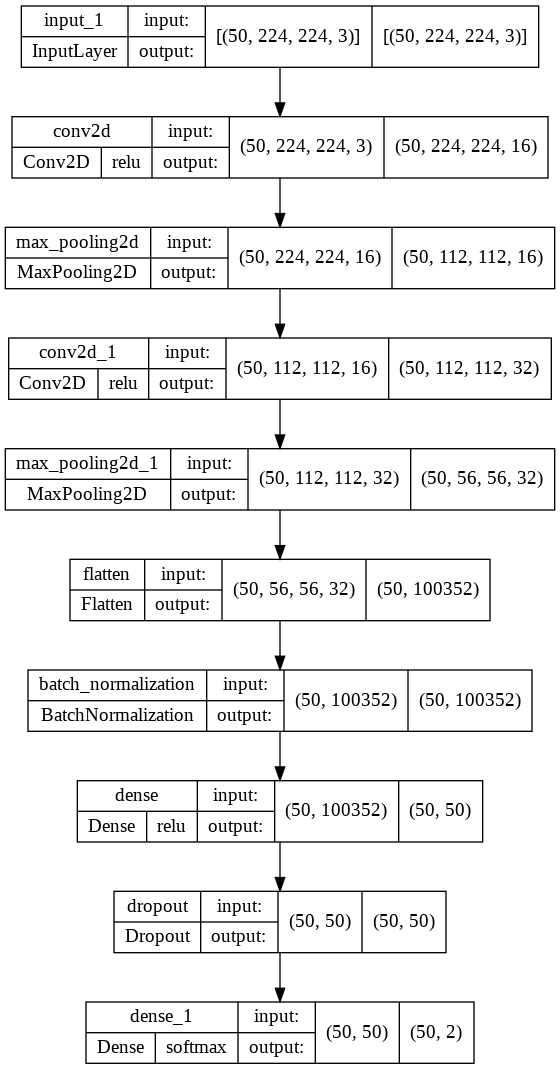

In [29]:
tf.keras.utils.plot_model(largeModel_10000,to_file="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/largeModel_10000.png",show_shapes=True,show_layer_names=True,show_layer_activations=True)


In [30]:
%%time
history = largeModel_10000.fit(total_train_dataset,epochs=10,validation_data=total_val_dataset,verbose=1)

Epoch 1/10
200/200 [==============================] - 29s 83ms/step - loss: 0.4505 - accuracy: 0.9394 - val_loss: 0.4898 - val_accuracy: 0.5462
Epoch 2/10
200/200 [==============================] - 17s 83ms/step - loss: 0.0918 - accuracy: 0.9702 - val_loss: 0.2345 - val_accuracy: 0.9812
Epoch 3/10
200/200 [==============================] - 17s 85ms/step - loss: 0.0602 - accuracy: 0.9787 - val_loss: 0.0563 - val_accuracy: 0.9812
Epoch 4/10
200/200 [==============================] - 17s 85ms/step - loss: 0.0520 - accuracy: 0.9819 - val_loss: 0.0316 - val_accuracy: 0.9912
Epoch 5/10
200/200 [==============================] - 19s 94ms/step - loss: 0.0414 - accuracy: 0.9866 - val_loss: 0.1587 - val_accuracy: 0.9650
Epoch 6/10
200/200 [==============================] - 18s 87ms/step - loss: 0.0497 - accuracy: 0.9838 - val_loss: 0.2666 - val_accuracy: 0.9588
Epoch 7/10
200/200 [==============================] - 17s 86ms/step - loss: 0.0409 - accuracy: 0.9873 - val_loss: 0.0301 - val_accuracy:

In [31]:
%%time
largeModel_10000.evaluate(total_test_dataset)

18/18 [==============================] - 1s 73ms/step - loss: 0.1540 - accuracy: 0.9744
CPU times: user 2.41 s, sys: 112 ms, total: 2.52 s
Wall time: 2.62 s


[0.1539897620677948, 0.9744444489479065]

In [32]:
history.history

{'accuracy': [0.9394000172615051,
  0.9702000021934509,
  0.9786999821662903,
  0.9818999767303467,
  0.9865999817848206,
  0.9837999939918518,
  0.9872999787330627,
  0.9886999726295471,
  0.9869999885559082,
  0.9866999983787537],
 'loss': [0.45049339532852173,
  0.09184393286705017,
  0.06016607582569122,
  0.052002277225255966,
  0.04142121970653534,
  0.04966631904244423,
  0.040920890867710114,
  0.03529448062181473,
  0.04077107086777687,
  0.0373714342713356],
 'val_accuracy': [0.5462499856948853,
  0.981249988079071,
  0.981249988079071,
  0.9912499785423279,
  0.9649999737739563,
  0.9587500095367432,
  0.9912499785423279,
  0.9925000071525574,
  0.9887499809265137,
  0.9800000190734863],
 'val_loss': [0.4897541403770447,
  0.23454535007476807,
  0.056270793080329895,
  0.0315549261868,
  0.15872722864151,
  0.26662585139274597,
  0.030052032321691513,
  0.02912346087396145,
  0.03962703049182892,
  0.08376850932836533]}

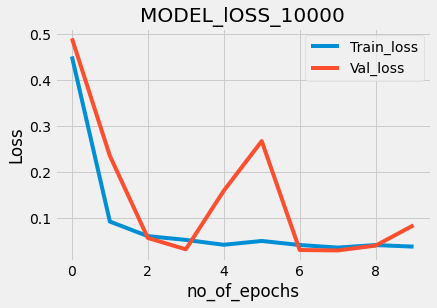

In [41]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("MODEL_lOSS_10000")
plt.ylabel("Loss")
plt.xlabel("no_of_epochs")
plt.legend(["Train_loss","Val_loss"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_loss_10000")
plt.show()

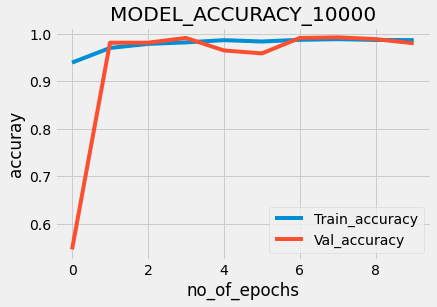

In [34]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("MODEL_ACCURACY_10000")
plt.xlabel("no_of_epochs")
plt.ylabel("accuray")
plt.legend(["Train_accuracy","Val_accuracy"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_accuracy_10000")
plt.show()


In [35]:
y_test = []
x_test = []
for img,label in total_test_dataset:
  for img_label in label:
    y_test.append(img_label.numpy())
  for images in img:
    x_test.append(images.numpy())
x_test = np.array(x_test)
y_test = np.array(y_test)
len(y_test) , len(x_test) , len(total_test_dataset) , x_test.shape  , y_test.shape

(900, 900, 18, (900, 224, 224, 3), (900,))

In [36]:
y_predict = largeModel_10000.predict([x_test])
y_predict.shape , y_predict[0]

((900, 2), array([3.841604e-15, 1.000000e+00], dtype=float32))

In [37]:
y_predict_final = []
for x in y_predict:
    y_predict_final.append(np.argmax(x))
y_predict_final = np.array(y_predict_final)
y_predict_final.shape  , y_test.shape

((900,), (900,))

In [38]:
clasi_report  = classification_report(y_true=y_test,y_pred=y_predict_final)
print(clasi_report)

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       450
         1.0       1.00      0.95      0.97       450

    accuracy                           0.97       900
   macro avg       0.98      0.97      0.97       900
weighted avg       0.98      0.97      0.97       900



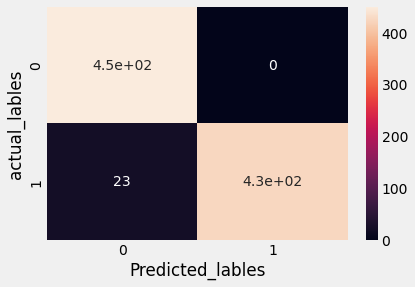

In [39]:
import seaborn as sn
cf_matrix = confusion_matrix(y_test,y_predict_final)
sn.heatmap(cf_matrix,annot=True)
plt.xlabel("Predicted_lables")
plt.ylabel("actual_lables")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/CFMat_largeModel_10000")
plt.show()

In [40]:
tf.keras.models.save_model(model=largeModel_10000,filepath="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/largeModel_10000")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/largeModel_10000/assets


Model with 5000 pictures model

In [42]:
total_train_With_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Train/WithMask/*.png")
total_train_WithOut_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Train/WithoutMask/*.png")
total_test_With_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Test/WithMask/*.png")
total_test_WithOut_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Test/WithoutMask/*.png")
total_val_With_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Validation/WithMask/*.png")
total_val_WithOut_mask_dataset = tf.data.Dataset.list_files("/content/Face Mask Dataset/Validation/WithoutMask/*.png")
len(total_train_With_mask_dataset) , len(total_train_WithOut_mask_dataset) , len(total_test_With_mask_dataset) , len(total_test_WithOut_mask_dataset) , len(total_val_With_mask_dataset) , len(total_val_WithOut_mask_dataset)

(5000, 5000, 450, 450, 400, 400)

In [43]:
train_5000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_train_With_mask_dataset,total_train_WithOut_mask_dataset],weights=[.5,.5])
test_5000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_test_With_mask_dataset,total_test_WithOut_mask_dataset],weights=[1.0,1.0])
val_5000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_val_With_mask_dataset,total_val_WithOut_mask_dataset],weights=[1.0,1.0])

In [44]:
train_5000_dataset = train_5000_dataset.map(get_img_label).batch(batch_size=batchSize).prefetch(tf.data.AUTOTUNE)
val_5000_dataset = val_5000_dataset.map(get_img_label).batch(batch_size=batchSize)
test_5000_dataset = test_5000_dataset.map(get_img_label).batch(batch_size = batchSize)
for img,label in train_5000_dataset.take(1):
  print(img.shape)
  print(label.shape)
for img,label in test_5000_dataset.take(1):
  print(img.shape)
  print(label.shape)

(50, 224, 224, 3)
(50,)
(50, 224, 224, 3)
(50,)


In [45]:
largeModel_5000 = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224,224,3),batch_size=batchSize),
        tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50,activation="relu"),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2,activation="softmax")
])
largeModel_5000.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [46]:
%%time
history_5000 = largeModel_5000.fit(train_5000_dataset,epochs=8,validation_data=val_5000_dataset,verbose=1)

Epoch 1/8
200/200 [==============================] - 23s 110ms/step - loss: 0.6516 - accuracy: 0.9333 - val_loss: 0.4729 - val_accuracy: 0.6225
Epoch 2/8
200/200 [==============================] - 20s 101ms/step - loss: 0.1500 - accuracy: 0.9607 - val_loss: 1.0819 - val_accuracy: 0.5950
Epoch 3/8
200/200 [==============================] - 21s 106ms/step - loss: 0.1919 - accuracy: 0.9119 - val_loss: 0.0920 - val_accuracy: 0.9837
Epoch 4/8
200/200 [==============================] - 21s 107ms/step - loss: 0.1002 - accuracy: 0.9665 - val_loss: 0.6849 - val_accuracy: 0.7038
Epoch 5/8
200/200 [==============================] - 20s 98ms/step - loss: 0.1329 - accuracy: 0.9612 - val_loss: 0.0631 - val_accuracy: 0.9875
Epoch 6/8
200/200 [==============================] - 20s 98ms/step - loss: 0.0603 - accuracy: 0.9805 - val_loss: 0.0833 - val_accuracy: 0.9787
Epoch 7/8
200/200 [==============================] - 19s 96ms/step - loss: 0.0600 - accuracy: 0.9840 - val_loss: 0.0628 - val_accuracy: 0.

In [47]:
%%time
largeModel_5000.evaluate(test_5000_dataset)

18/18 [==============================] - 2s 83ms/step - loss: 0.0871 - accuracy: 0.9711
CPU times: user 2.39 s, sys: 456 ms, total: 2.85 s
Wall time: 2.63 s


[0.08710253983736038, 0.9711111187934875]

In [48]:
history_5000.history

{'accuracy': [0.9333000183105469,
  0.9606999754905701,
  0.911899983882904,
  0.9664999842643738,
  0.9611999988555908,
  0.9804999828338623,
  0.984000027179718,
  0.9796000123023987],
 'loss': [0.6516036987304688,
  0.14998842775821686,
  0.19191157817840576,
  0.10015921294689178,
  0.13285325467586517,
  0.06028583273291588,
  0.059965234249830246,
  0.06968984752893448],
 'val_accuracy': [0.6225000023841858,
  0.5950000286102295,
  0.9837499856948853,
  0.7037500143051147,
  0.987500011920929,
  0.9787499904632568,
  0.9825000166893005,
  0.9800000190734863],
 'val_loss': [0.47285157442092896,
  1.08186674118042,
  0.09197776019573212,
  0.6848738193511963,
  0.06314891576766968,
  0.08332120627164841,
  0.06275451183319092,
  0.05760235711932182]}

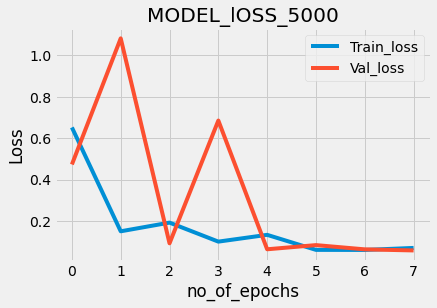

In [49]:
plt.plot(history_5000.history["loss"])
plt.plot(history_5000.history["val_loss"])
plt.title("MODEL_lOSS_5000")
plt.ylabel("Loss")
plt.xlabel("no_of_epochs")
plt.legend(["Train_loss","Val_loss"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_loss_5000")
plt.show()

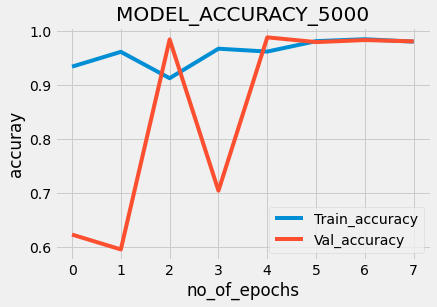

In [50]:
plt.plot(history_5000.history["accuracy"])
plt.plot(history_5000.history["val_accuracy"])
plt.title("MODEL_ACCURACY_5000")
plt.xlabel("no_of_epochs")
plt.ylabel("accuray")
plt.legend(["Train_accuracy","Val_accuracy"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_Accuracy_5000")
plt.show()

In [51]:
y_test_5000 = []
x_test_5000 = []
for img,label in test_5000_dataset:
  for img_label in label:
    y_test_5000.append(img_label.numpy())
  for images in img:
    x_test_5000.append(images.numpy())
x_test_5000 = np.array(x_test_5000)
y_test_5000 = np.array(y_test_5000)
y_predict_5000 = largeModel_5000.predict([x_test_5000])
y_predict_final_5000 = []
for x in y_predict_5000:
    y_predict_final_5000.append(np.argmax(x))
y_predict_final_5000 = np.array(y_predict_final_5000)
y_predict_final_5000.shape  , y_test_5000.shape

((900,), (900,))

In [52]:
clasi_report_5000  = classification_report(y_true=y_test_5000,y_pred=y_predict_final_5000)
print(clasi_report_5000)

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       450
         1.0       0.95      1.00      0.97       450

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



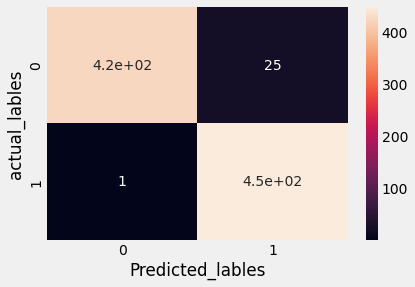

In [53]:
cf_matrix_5000 = confusion_matrix(y_test_5000,y_predict_final_5000)
sn.heatmap(cf_matrix_5000,annot=True)
plt.xlabel("Predicted_lables")
plt.ylabel("actual_lables")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/CFMat_largeModel_5000")

plt.show()

In [54]:
tf.keras.models.save_model(model=largeModel_5000,filepath="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/largeModel_5000")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/largeModel_5000/assets


Model 1000 model


In [55]:
5000/500


10.0

In [79]:
train_1000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_train_With_mask_dataset,total_train_WithOut_mask_dataset],weights=[.1,.1])
test_1000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_test_With_mask_dataset,total_test_WithOut_mask_dataset],weights=[1.0,1.0])
val_1000_dataset = tf.data.Dataset.sample_from_datasets(datasets=[total_val_With_mask_dataset,total_val_WithOut_mask_dataset],weights=[1.0,1.0])

In [80]:
train_1000_dataset = train_1000_dataset.map(get_img_label).batch(batch_size=batchSize).prefetch(tf.data.AUTOTUNE)
val_1000_dataset = val_1000_dataset.map(get_img_label).batch(batch_size=batchSize)
test_1000_dataset = test_1000_dataset.map(get_img_label).batch(batch_size = batchSize)
for img,label in train_1000_dataset.take(1):
  print(img.shape)
  print(label.shape)
for img,label in test_1000_dataset.take(1):
  print(img.shape)
  print(label.shape)

(50, 224, 224, 3)
(50,)
(50, 224, 224, 3)
(50,)


In [81]:
smallmodel_1000 = tf.keras.Sequential([
         tf.keras.layers.InputLayer(input_shape=(224,224,3),batch_size=batchSize),
        tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50,activation="relu"),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(2,activation="softmax")
])
smallmodel_1000.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])

In [82]:
%%time
history_1000 = smallmodel_1000.fit(train_1000_dataset,epochs=10,validation_data=val_1000_dataset,verbose=1)

Epoch 1/10
200/200 [==============================] - 18s 86ms/step - loss: 0.3497 - accuracy: 0.9305 - val_loss: 0.5695 - val_accuracy: 0.6625
Epoch 2/10
200/200 [==============================] - 17s 86ms/step - loss: 0.1599 - accuracy: 0.9514 - val_loss: 0.1408 - val_accuracy: 0.9500
Epoch 3/10
200/200 [==============================] - 17s 84ms/step - loss: 0.1028 - accuracy: 0.9706 - val_loss: 0.1019 - val_accuracy: 0.9762
Epoch 4/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1169 - accuracy: 0.9642 - val_loss: 0.1051 - val_accuracy: 0.9825
Epoch 5/10
200/200 [==============================] - 17s 84ms/step - loss: 0.0686 - accuracy: 0.9788 - val_loss: 0.0325 - val_accuracy: 0.9912
Epoch 6/10
200/200 [==============================] - 17s 84ms/step - loss: 0.0680 - accuracy: 0.9789 - val_loss: 0.0358 - val_accuracy: 0.9850
Epoch 7/10
200/200 [==============================] - 17s 85ms/step - loss: 0.0912 - accuracy: 0.9694 - val_loss: 0.6643 - val_accuracy:

In [83]:
%%time
smallmodel_1000.evaluate(test_1000_dataset)

18/18 [==============================] - 2s 113ms/step - loss: 0.0928 - accuracy: 0.9700
CPU times: user 2.52 s, sys: 110 ms, total: 2.63 s
Wall time: 2.24 s


[0.09278899431228638, 0.9700000286102295]

In [84]:
history_1000.history

{'accuracy': [0.9304999709129333,
  0.9513999819755554,
  0.9706000089645386,
  0.9642000198364258,
  0.9787999987602234,
  0.9789000153541565,
  0.9693999886512756,
  0.9606999754905701,
  0.9804999828338623,
  0.9670000076293945],
 'loss': [0.34973737597465515,
  0.1598917692899704,
  0.10281417518854141,
  0.11685255169868469,
  0.06858454644680023,
  0.06797909736633301,
  0.09115112572908401,
  0.14389877021312714,
  0.07367278635501862,
  0.09172629565000534],
 'val_accuracy': [0.6625000238418579,
  0.949999988079071,
  0.9762499928474426,
  0.9825000166893005,
  0.9912499785423279,
  0.9850000143051147,
  0.7437499761581421,
  0.987500011920929,
  0.96875,
  0.9850000143051147],
 'val_loss': [0.5695239901542664,
  0.14075320959091187,
  0.10185312479734421,
  0.10507470369338989,
  0.032498519867658615,
  0.03581472858786583,
  0.6642780900001526,
  0.043260712176561356,
  0.08469849824905396,
  0.06941737979650497]}

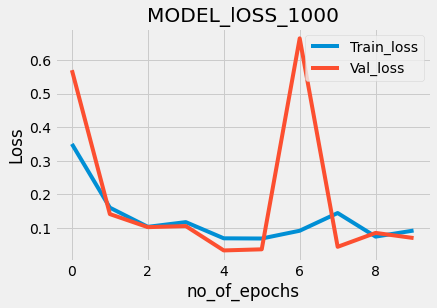

In [85]:
plt.plot(history_1000.history["loss"])
plt.plot(history_1000.history["val_loss"])
plt.title("MODEL_lOSS_1000")
plt.ylabel("Loss")
plt.xlabel("no_of_epochs")
plt.legend(["Train_loss","Val_loss"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_loss_1000")
plt.show()

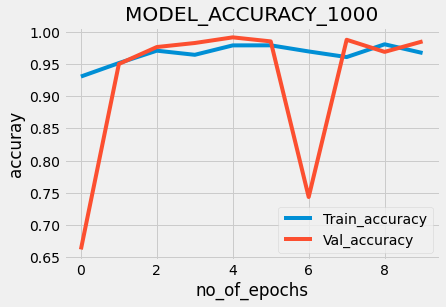

In [86]:
plt.plot(history_1000.history["accuracy"])
plt.plot(history_1000.history["val_accuracy"])
plt.title("MODEL_ACCURACY_1000")
plt.xlabel("no_of_epochs")
plt.ylabel("accuray")
plt.legend(["Train_accuracy","Val_accuracy"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_Accuracy_1000")
plt.show()

In [87]:
y_test_1000 = []
x_test_1000 = []
for img,label in test_1000_dataset:
  for img_label in label:
    y_test_1000.append(img_label.numpy())
  for images in img:
    x_test_1000.append(images.numpy())
x_test_1000 = np.array(x_test_1000)
y_test_1000 = np.array(y_test_1000)
y_predict_1000 = smallmodel_1000.predict([x_test_1000])
y_predict_final_1000 = []
for x in y_predict_1000:
    y_predict_final_1000.append(np.argmax(x))
y_predict_final_1000 = np.array(y_predict_final_1000)
y_predict_final_1000.shape  , y_test_1000.shape

((900,), (900,))

In [88]:
clasi_report_1000  = classification_report(y_true=y_test_1000,y_pred=y_predict_final_1000)
print(clasi_report_1000)

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       450
         1.0       0.96      0.98      0.97       450

    accuracy                           0.97       900
   macro avg       0.97      0.97      0.97       900
weighted avg       0.97      0.97      0.97       900



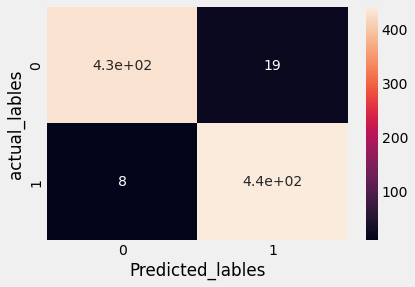

In [89]:
cf_matrix_1000 = confusion_matrix(y_test_1000,y_predict_final_1000)
sn.heatmap(cf_matrix_1000,annot=True)
plt.xlabel("Predicted_lables")
plt.ylabel("actual_lables")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/CFMat_SmallModel_1000")

plt.show()

In [90]:
tf.keras.models.save_model(model=smallmodel_1000,filepath="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/SmallModel_1000")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/SmallModel_1000/assets


Transfer_learning for same 500 sample each(total dataset of 1000)

In [91]:
images_shape = (224,224)
classifier = tf.keras.Sequential([
    tf_hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4",input_shape=images_shape+(3,) )
])
classifier

In [92]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_withOut_topLayers = tf_hub.KerasLayer(feature_extractor_model,input_shape=(224,224,3),trainable=False)
pretrained_model_withOut_topLayers

In [93]:
small_tranvers_model = tf.keras.Sequential([
    pretrained_model_withOut_topLayers,
    tf.keras.layers.Dense(50,activation="relu"),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(2,activation="softmax")
])
small_tranvers_model.compile(optimizer="Adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=["accuracy"])
small_tranvers_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_10 (Dense)            (None, 50)                64050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 102       
                                                                 
Total params: 2,322,136
Trainable params: 64,152
Non-trainable params: 2,257,984
_________________________________________________________________


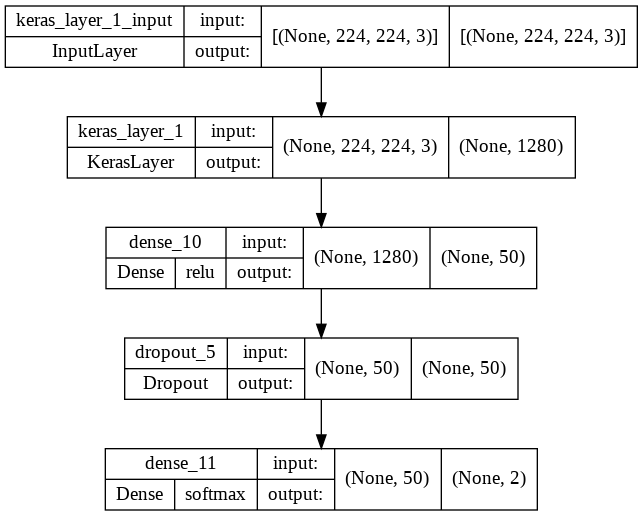

In [94]:
tf.keras.utils.plot_model(small_tranvers_model,to_file="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/tranfer_learning.png",show_shapes=True,show_layer_names=True,show_layer_activations=True)

In [95]:
%%time
history_tranfer_1000 = small_tranvers_model.fit(train_1000_dataset,epochs=10,validation_data=val_1000_dataset,verbose=1)

Epoch 1/10
200/200 [==============================] - 356s 2s/step - loss: 0.0449 - accuracy: 0.9853 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 2/10
200/200 [==============================] - 298s 1s/step - loss: 0.0091 - accuracy: 0.9967 - val_loss: 0.0052 - val_accuracy: 0.9975
Epoch 3/10
200/200 [==============================] - 301s 2s/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/10
200/200 [==============================] - 297s 1s/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0038 - val_accuracy: 0.9987
Epoch 5/10
200/200 [==============================] - 295s 1s/step - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 6/10
200/200 [==============================] - 295s 1s/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 9.5908e-04 - val_accuracy: 1.0000
Epoch 7/10
200/200 [==============================] - 295s 1s/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 4.5805e-04 - val_accuracy

In [96]:
%%time
small_tranvers_model.evaluate(test_1000_dataset)

18/18 [==============================] - 25s 1s/step - loss: 0.0012 - accuracy: 1.0000
CPU times: user 45.8 s, sys: 1.37 s, total: 47.2 s
Wall time: 24.8 s


[0.001218601013533771, 1.0]

In [97]:
history_tranfer_1000.history

{'accuracy': [0.9853000044822693,
  0.9966999888420105,
  0.9980000257492065,
  0.9986000061035156,
  0.9983000159263611,
  0.9990000128746033,
  0.9993000030517578,
  0.9988999962806702,
  0.9987000226974487,
  0.9980999827384949],
 'loss': [0.04490046575665474,
  0.00913994014263153,
  0.0066176787950098515,
  0.004599698819220066,
  0.005050232633948326,
  0.003032316919416189,
  0.0021733338944613934,
  0.0027858801186084747,
  0.003665047464892268,
  0.005369062069803476],
 'val_accuracy': [1.0,
  0.9975000023841858,
  1.0,
  0.9987499713897705,
  0.9987499713897705,
  1.0,
  1.0,
  0.9975000023841858,
  0.9987499713897705,
  1.0],
 'val_loss': [0.003637813962996006,
  0.005203347187489271,
  0.002027314156293869,
  0.003803079714998603,
  0.0032083054538816214,
  0.0009590849513188004,
  0.00045805281843058765,
  0.006984329782426357,
  0.0031791748479008675,
  0.0006572832353413105]}

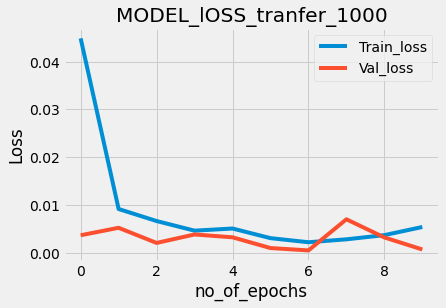

In [98]:
plt.plot(history_tranfer_1000.history["loss"])
plt.plot(history_tranfer_1000.history["val_loss"])
plt.title("MODEL_lOSS_tranfer_1000")
plt.ylabel("Loss")
plt.xlabel("no_of_epochs")
plt.legend(["Train_loss","Val_loss"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_loss_tranfer_1000")
plt.show()

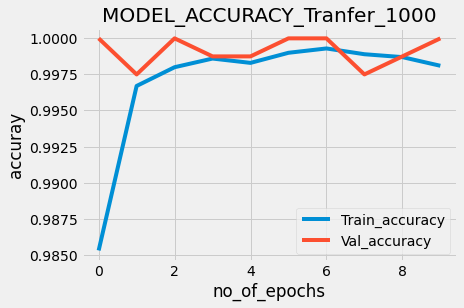

In [99]:
plt.plot(history_tranfer_1000.history["accuracy"])
plt.plot(history_tranfer_1000.history["val_accuracy"])
plt.title("MODEL_ACCURACY_Tranfer_1000")
plt.xlabel("no_of_epochs")
plt.ylabel("accuray")
plt.legend(["Train_accuracy","Val_accuracy"])
plt.style.use("fivethirtyeight")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/Model_loss_tranfer_1000")
plt.show()

In [100]:
y_test_1000_T = []
x_test_1000_T = []
for img,label in test_1000_dataset:
  for img_label in label:
    y_test_1000_T.append(img_label.numpy())
  for images in img:
    x_test_1000_T.append(images.numpy())
x_test_1000_T = np.array(x_test_1000_T)
y_test_1000_T = np.array(y_test_1000_T)
y_predict_1000_T = small_tranvers_model.predict([x_test_1000_T])
y_predict_final_1000_T = []
for x in y_predict_1000_T:
    y_predict_final_1000_T.append(np.argmax(x))
y_predict_final_1000_T= np.array(y_predict_final_1000_T)
y_predict_final_1000_T.shape  , y_test_1000_T.shape

((900,), (900,))

In [101]:
clasi_report_1000_T  = classification_report(y_true=y_test_1000_T,y_pred=y_predict_final_1000_T)
print(clasi_report_1000_T)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       450
         1.0       1.00      1.00      1.00       450

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



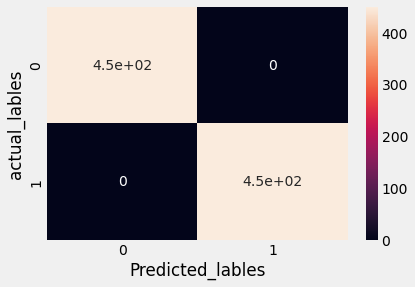

In [102]:
cf_matrix_1000_T = confusion_matrix(y_test_1000_T,y_predict_final_1000_T)
sn.heatmap(cf_matrix_1000_T,annot=True)
plt.xlabel("Predicted_lables")
plt.ylabel("actual_lables")
plt.savefig("/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/CFMat_TranferModel_1000")

plt.show()

In [103]:
tf.keras.models.save_model(model=small_tranvers_model,filepath="/content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/SmallModel_Tranfer_1000")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/SmallModel_Tranfer_1000/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FACE_MASK_PAPER/models_filesandPics/SmallModel_Tranfer_1000/assets
